# MaskGIT: Masked Generative Image Transformer
- Authors: Huiwen Chang, Han Zhang, Lu Jiang, Ce Liu, William T. Freeman
- Paper link: __[Arxiv](https://arxiv.org/abs/2202.04200)__
- Conference: CVPR2022

## Project Group 04
- Ardan Yılmaz, 2172195: yilmaz.ardan@metu.edu.tr
- Şahin Umutcan Üstündaş, 2099703: umutcan.ustundas@metu.edu.tr

## Paper Summary

In this paper, the authors propose a novel masking method and a bidirectional transformer decoder, named MaskGIT. The model learns to predict randomly masked tokens by attending to tokens in all directions. Then, during inference, the model generates all of the tokens simultaneously in an iterative manner. With this way, the model decodes every pixel simultaneously, which speeds up the generation process by up to 64x, as claimed by the paper.

The proposed framework has two stages:
1) First, a tokenizer tokenizes the image into visual tokens
2) Second, the tokens are masked with a masking scheme and a bidirectional transformer predicts the masked tokens (Masked Visual Token Modeling - MVTM)

The masking operation uses random sampling in training time by using a scheduling function. However, during the inference time, the sampling ratio is changed with t/T, where T is the total number of iterations, and t is the current number of iteration.

For inference, the authors propose Iterative Decoding process.

Given an image, we first tokenize the image, and at each iteration, 

    1) We feed it to the transformer and calculate the probabilities for all the masked locations at once
    2) At each masked location, we sample a token and find a confidence score.
    3) We compute the mask
    4) Mask the tokens
    5) GOTO 1)

For the scope of the paper, the authors used the same setup for the first stage as it is done in VQGAN model, and focused on MVTM.

## Model Overview

![Overview](figures/Overview.png)

Taken from MaskGIT paper.

## Model Architecture

We used a similar method described in the paper for implementation.

- We used a pretrained VQGAN encoder from "Taming Transformers for High-Resolution Image Synthesis" by Patrick Esser, et al. for extracting visual tokens.
- We implemented the MVTM method described in MaskGIT paper.

**DRAW A MODEL SCHEMA HERE**

## Model Hyperparameters

We tried to keep the hyperparameters as same as possible to the ones reported in the MaskGIT paper.

- Batch size: 256 (as in paper)
- Embedding dimensions: 768 (as in paper)
- Attention heads: 8 (as in paper)
- Number of transformer blocks: 24 (as in paper)
- Number of hidden dimensions: 3072 (as in paper)
- Codebook size: 1024 (as in paper)

## Implementation

### Training
Below is how the training process is implemented:






```
    # Image Encoding
    # Encode raw pixel data of images using a pre-trained tokenizer
    # Obtain quantized embeddings and min_encoding_indices
    # Reshape min_encoding_indices to match the shape of quantized embeddings

    # Mask Creation
    # Create a binary mask using the create_mask method
    # This returns a tensor with a certain fraction of values set to True (to be masked)
    
    # Applying the Mask to the Input
    # Expand the mask to match the size of the batch
    # Replace all positions in min_encoding_indices corresponding to True in the mask tensor with the mask_token 

    # Adding the Start-of-Sequence (SOS) Token
    # Create a tensor of SOS tokens of the same batch size
    # Concatenate the SOS tokens to the beginning of the min_encoding_indices

    # Transformer Model
    # Feed the masked min_encoding_indices with the SOS tokens into the transformer model
    # Obtain the output logits

    # Output
    # The output of the forward function is the logits and the original min_encoding_indices (used as labels)
```








In [1]:
import torch
from trainer import train
from inference import infer_image
from argparse import Namespace

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

%load_ext autoreload
%autoreload 2

In [2]:
pretrained_model_path = "SavedModels/epoch_22_model.pt"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_path = "Data/Imagenet64"

In [3]:
# Define global parameters here!
args = Namespace(epochs = 300,
                batch_size = 256,
                ckpt_interval = 1,
                dim = 768,
                hidden_dim = 3072,
                n_layers = 24,
                num_codebook_vectors = 1024,
                num_img_tok = 256,
                mask_token = 1024,
                iters = 8,
                samples=4,
                model_path = pretrained_model_path,
                device = DEVICE,
                dataset_path = dataset_path)


In [ ]:
# This cell takes too much time, so we do not run this!

train(args)

#### For inference, we aimed to apply image inpainting, ie, masking a part of the image, we try to reconstruct it.

The inference is implemented as follows:





```
# Get empty canvas for input images
# get input tokens from encoder

for t in range(iterations):
  # Get logits from the transformer
  logits = self.transformer(input_tokens)

  # Calculate probabilities
  probs = nn.Softmax(dim=-1)(logits)

  # Sample ids with their probability score

  # Calculate confidence scores

  # Get the mask using dynamic masking strategy

  # Update current ids, mask tokens with lower confidence

# Return the filled canvas with decoder
return self.decoder(input_tokens)```





Train loss:

![Overview](figures/loss_22.png)


We should note that the model is still training.

### Inference

cuda:0
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/home/umut/anaconda3/envs/maskgit/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/umut/anaconda3/envs/maskgit/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
torch.Size([3, 64, 64])
torch.Size([4, 3, 64, 64])


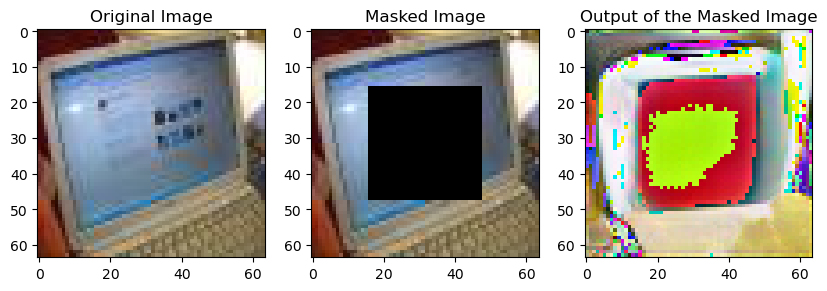

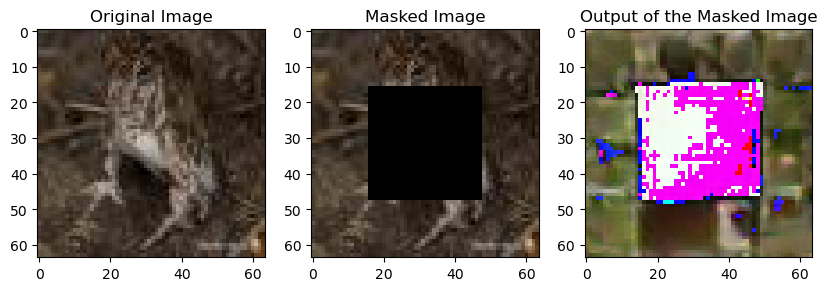

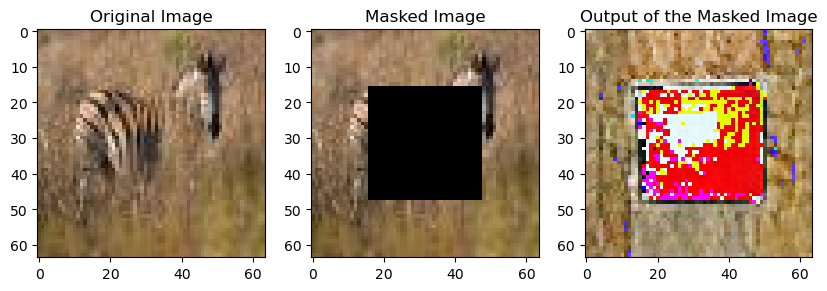

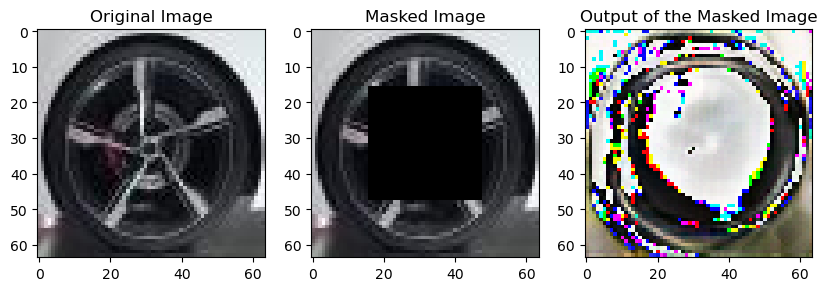

In [4]:
infer_image(args)

## Challenges

We have faced several difficulties while working on the project.
1) Our main challenge was that our hardware was limited, compared to the authors. Therefore, we switched from the Imagenet dataset to a smaller Imagenet64 dataset.
2) The Bidirectional Transformer part was not detailed in the paper, so we had to read into other related papers in order to have a better understanding of the paper.